<span style="font-size:12px">

#### ▶ BERT : 양쪽 문맥을 이해
 - 문장을 양 방향을 모두 보면서 이해하고 빈칸을 채움 ( 기존모델은 보통 왼쪽에서 오른쪽으로 한방향)

##### ▶ BERT 흐름
 - 데이터 
 - Hugging Face Transformers Pipeline ( 간단한 api)
 - 토크나이저 (텍스트 --> 토큰 --> 숫자 ID)
 - 사전학습된 모델 (BERT, GPT-2, DistilBERT 등)
 - 예측 결과(감성분석, 텍스트 생성, 문장 유사도)
 - 후처리 평가 (확률 변환, 정확도 계산)

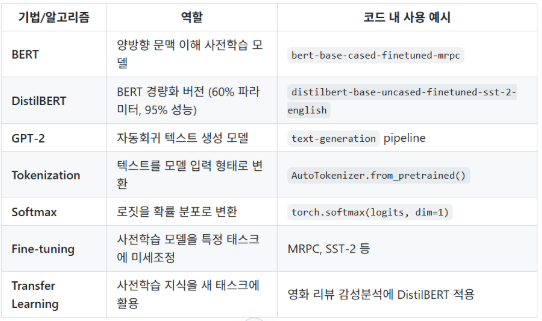

<span style="font-size:12px">

- 예시 문장: I want to the [MASK] to buy some milk
- BERT 예측 : [MASK] --> "store" (앞뒤 문맥인 buy, milk를 보고 추론)

##### ▶ 사전 학습 방법
 - MLM(Mask Language Model) : 문장의 15% 단어를 MASK 처리한 다음 예측
 - NSP(Next Sentence Prediction) : 두 문장이 연결되는지를 판단

사전학습(대규모 테스트)
[CLS] token 추가
특정 데스크 레이블로 학습 (감성분석, QA 등)

<span style="font-size:12px">
===============================

#### ▶ Distil BERT : 
 - BERT 압축버전 : 속도는 2배 빠르다 성능은 95% 유지함
 - 두꺼운 교과서(BERT)의 핵심만 추린 요약본(DistilBERT)
 - 파라미터수 ~40% 감소, 속도 ~60% 증가, 성능 ~95% 수준
 
#### ▶ 지식증류 (Knowldege Distillation)
 - Teacher 모델(BERT) : 소프트레이블 생성(확률분포)
 - Student 모델(DistilBERT) : Teacher 출력을 모방

==============================

#### ▶ GPT-2
 - 이전단어들을 보고 다음 단어를 예측 (문장을 "생성"하는데 특화된 언어모델)
 - 단방향 Attention : 
 - Zero-shot Learning : 특정 테스트 학습 없이도 수행 가능
 - GPT 시리즈
    - GPT-1 : 117M 파라메터
    - GPT-2 : 1.5B 파라메터
    - GPT-3 : 175B 파라메터 (Rew-shot Learning)
    - GPT-4 : 멀티모달 (이미지와 텍스트를 같이 보고 학습)

In [ ]:
import numpy as np
def softmax(logits): 
    '''
    logits을 확률 분포로 변환
    Args:
        logits: 모델의 출력 점수 ( [2.5, 1.0, 0.5])
    returns : 
        확률 분포 (합이 1인 배열)
    '''
    # 수치 안정성을 위해 최대값을 빼줌 (오버플로우 방지)
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits/ np.sum(exp_logits)

logits = np.array([2.5, 1.0, 0.5])
probs = softmax(logits)
print(f' logits : {logits}')
print(f'softmax : {probs}')
print(f'softmax sum : {np.sum(probs)}')

 logits : [2.5 1.  0.5]
softmax : [0.73612472 0.16425163 0.09962365]
softmax sum : 0.9999999999999999


#### WordPiece : Word + Piece
 - 단어를 자주 등장하는 조각(piece) 단위로 잘라서 처리
 - 기존 토크나이저 대비 --> 더 잘게 쪼개자 (Subword)
 - 예시 playing --> play + ##ing  ##앞 조각에 붙는 서브워드 라는 의미
 - 예시 득템 -----> 득 + 템

In [ ]:
# %conda install transformers
# %conda install ipywidgets

## WordPiece 토큰화 시뮬레이션

In [14]:
##### WordPiece 토큰화 시뮬레이션
from transformers import AutoTokenizer
# BERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  #uncased : 다국어를 지원
# 테스트 문장
sentence = 'I love natural language processing!'
print(f'원본문장 : {sentence}')
# 토큰화
tokens = tokenizer.tokenize(sentence)
print(f'토큰화/목록 : {tokens}')
tokens_ids = tokenizer.encode(sentence)
print(f'토큰ID : {tokens_ids}')  #이 모델이 이미 가지고 있는 단어사전에 매칭된 숫자가 나옴 (이미 사전학습된 모델이라 전처럼 단어사전화 할 필요 없음)
# 디코딩
decoded = tokenizer.decode(tokens_ids)
print(f'디코딩 결과 : {decoded}')   #[CLS] 문장 시작, [SEP] 문장끝

print ('==============================')
print(f'CSL토큰 : {tokenizer.cls_token} --> {tokenizer.cls_token_id}')
print(f'SEP토큰 : {tokenizer.sep_token} --> {tokenizer.sep_token_id}')
print(f'PAD토큰 : {tokenizer.pad_token} --> {tokenizer.pad_token_id}')


원본문장 : I love natural language processing!
토큰화/목록 : ['i', 'love', 'natural', 'language', 'processing', '!']
토큰ID : [101, 1045, 2293, 3019, 2653, 6364, 999, 102]
디코딩 결과 : [CLS] i love natural language processing! [SEP]
CSL토큰 : [CLS] --> 101
SEP토큰 : [SEP] --> 102
PAD토큰 : [PAD] --> 0


## BERT 문장 유사도 판단

In [ ]:
#### BERT로 문장 유사도 판단
# AutoTokenizer : 지정한 모델 이름에 맞게 토크나이저를 자동으로 불러오는 클래스
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased-finetuned-mrpc')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased-finetuned-mrpc')
# 수만들기

def check_similarity (sentence1, sentence2):
    '''
    두 문장의 의미적 유사도를 판단
    Returns:
        유사확률(0~1사이 값)
    '''
    #1 토큰화
    inputs = tokenizer(sentence1, sentence2, return_tensors='pt')

    #2 모델추론
    with torch.no_grad():
        logits = model(**inputs).logits    #**inputs ..?왜?

    #3 softmax로 확률 변환
        probs = torch.softmax(logits, dim=1)[0]  #0은 배치이기 때문에, 배치를 제거..dim=1?

    #4 결과 반환
    return{
        'not_similar' : probs[0].item(),
        'similar': probs[1].item()
    }


# 테스트케이스 확인
test_cases = [
("The cat is on the mat", "A feline is sitting on a rug"),
("I love pizza", "Python is a programming language"),
("He runs fast", "She walks slowly"),
("I love you",  "You love me"),
("I hate you", "I love you"),
("I want to something to drink", "I need to water"),
("i sick long time", "i am not healthy")
]
for sent1, sent2 in test_cases:
    result = check_similarity(sent1, sent2)
    print(f'문장1 : {sent1}')
    print(f'문장2 : {sent2}')
    print(f'유사확률 : {result}')
    print('==================')
    



문장1 : The cat is on the mat
문장2 : A feline is sitting on a rug
유사확률 : {'not_similar': 0.09763294458389282, 'similar': 0.9023670554161072}
문장1 : I love pizza
문장2 : Python is a programming language
유사확률 : {'not_similar': 0.9627317190170288, 'similar': 0.03726824373006821}
문장1 : He runs fast
문장2 : She walks slowly
유사확률 : {'not_similar': 0.8916625380516052, 'similar': 0.10833746194839478}
문장1 : I love you
문장2 : You love me
유사확률 : {'not_similar': 0.09162463992834091, 'similar': 0.9083753228187561}
문장1 : I hate you
문장2 : I love you
유사확률 : {'not_similar': 0.44309157133102417, 'similar': 0.5569084882736206}
문장1 : I want to something to drink
문장2 : I need to water
유사확률 : {'not_similar': 0.11566749215126038, 'similar': 0.8843324780464172}
문장1 : i sick long time
문장2 : i am not healthy
유사확률 : {'not_similar': 0.899638295173645, 'similar': 0.10036170482635498}


## GPT-2

##### 확률적 샘플링?

- The cat is on the 다음에 들어올 단어 후보와 확률
'''
mat    0.4
roof   0.25
bed    0.15
chair  0.10
floor  0.05

top-k 3 mat roof bed
top-p 0.8

mat    0.4 ----> 누적 0.40
roof   0.25 ---> 누적 0.65 = 0.4+0.25
bed    0.15 ---> 누적 0.80 = 0.65+0.15   =====> top-p 0.8 이기 때문에 멈춤
'''

In [ ]:
#### GPT-2
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# 모델로드
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# 함수만들길
def generate_text (prompt, max_length=30):
    '''
    프롬프트 기반으로 텍스트 생성
    Args:
        prompt : 시작문장
        max_length : 최대 토큰수
    '''
    #1 입력토큰화
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    #2 생성 (다양한 전략)
    with torch.no_grad():  # 추론(평가) 모드
        output=model.generate (
            input_ids,
            max_length = max_length,
            num_return_sequences = 1, #생성할 문장수
            temperature=0.8, #창의성 조절 (0.6~0.8 적당 / 1이 최대, 헛소리(환각)할 수 있음)
            top_k=50,   #샘플링 전략 상위 k개의 단어만 선택
            top_p=0.95,  #누적확률p 이상의 단어만
            do_sample = True,  #확률적 샘플링
            pad_token_id = tokenizer.eos_token_id  #gpt2는 eos 토큰을 사용
        )
        
    #3 디코딩
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text


# 테스트
prompts = [
    "Once upon a time",
    "In the year 2050,",
    "The secret to happiness is"
]

for prompt in prompts:
    result = generate_text(prompt)
    print(f'prompt: {prompt}')
    print(f'생성: {result}')
    print('===============')

prompt: Once upon a time
생성: Once upon a time, the three men were looking for a man who had a pistol in his possession. He had already shot himself, but he was
prompt: In the year 2050,
생성: In the year 2050, China is expected to overtake the U.S. for the first time, with the Chinese economy expected to overtake the U.
prompt: The secret to happiness is
생성: The secret to happiness is to be able to see it through your own eyes.

The key is to do things the right way.




- BertTokenizer : 직접호출
    - BERT 전용
    - bert-base-uncased, bert_base_cased 등 BERT 계열만 지원
    - 다른 모델에서는 사용 불가
    - 모델 전환시 코드 수정
    
- AutoTokenizer : 자동선택
    - BERT RoBERTa, GPT-2, T5 다양한 모델 지원
    - from_pretraned 에 모델이름을 넣으면 ??
    - 어떤 클래스가 선택되었는지 모름 --> 세부구현시 세부 오셥 확인 필요


## 시각화

    - 👉 히트맵은 Transformer attention이 “문장을 어떻게 이해하고 처리하는지” 를 보여주는 도구임
    - 👉 즉, 모델이 단어 간 관계, 문법, 문맥 의존성 을 어떻게 파악하는지 알아볼 수 있음
    - 👉 디버깅, 모델 분석, 설명 가능한 AI(XAI)에 매우 유용

c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


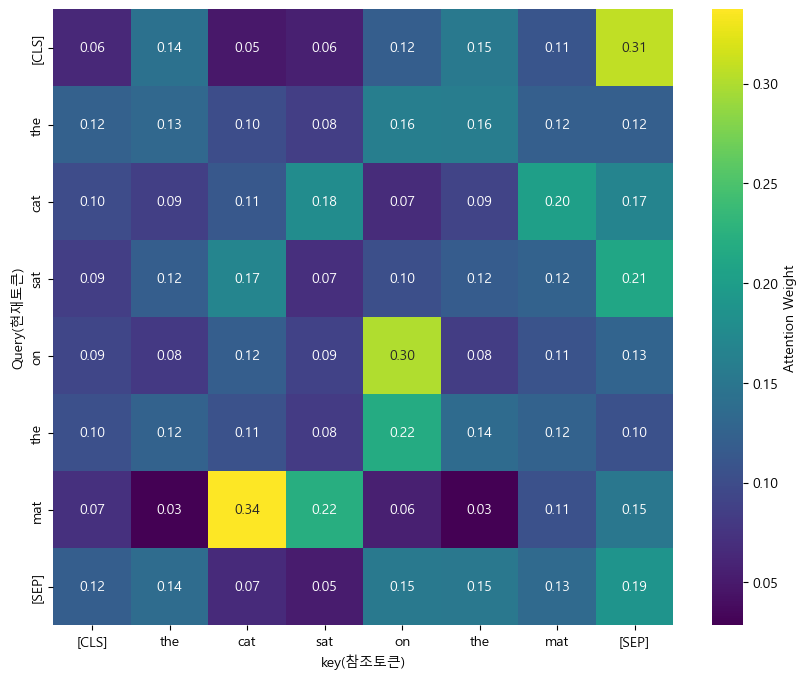

토큰 목록 : ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']
Attention 행렬크기 : (8, 8)


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# self-Attention 가중치 시각화
sentence = 'The cat sat on the mat'

# 1. 토큰화
inputs = tokenizer(sentence, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# 2. 모델 실행(Attention 추출)
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  #12개 레이어의 Ateetntion을 가지고있음.

# 3. 첫번째 레이어, 첫번째 헤드 
layer = 0
head = 0
attention = attentions[layer][0][head].numpy()  # shape: (seq_len, seq_len)
plt.figure(figsize=(10,8))
sns.heatmap(
    attention, 
    xticklabels=tokens,
    yticklabels=tokens,
    cmap = 'viridis',
    annot = True,
    fmt= '.2f',
    cbar_kws={'label': 'Attention Weight'}
)
plt.xlabel('key(참조토큰)')
plt.ylabel('Query(현재토큰)')
plt.show()
# 히트맵을 보면 알 수 있는 것들
# 1) 각 단어가 어떤 단어를 참고했는지(문맥)
#

print(f'토큰 목록 : {tokens}')
print(f'Attention 행렬크기 : {attention.shape}')

## BERT모델을 이용한 영화리뷰 감성분석

In [36]:
# BERT 모델을 이용해서 영화리뷰 감성분석
# 데이터셋: NLTK movie_revies
# 모델 DistilBERT
# 평가 : 분류리포트

import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
nltk.download('movie_reviews', quiet=True)
reviews = [movie_reviews.raw(id) for id in movie_reviews.fileids()]
categoris = [ movie_reviews.categories(id)[0] for id in movie_reviews.fileids()]
reviews
categoris

In [49]:
# 카테고리 pos --> 1, neg --> 0 변경
y = np.array([1 if ca == 'pos' else 0 for ca in categoris])
x_train, x_test, y_train, y_test = train_test_split(reviews, y, stratify=y, random_state=42)


# 모델
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


# 디바이스 지정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


# 예측함수
def predict_sentiment (texts, batch_size=0):
    '''
    배치단위로 감성 예측
    Arg:
        texts: 리뷰 텍스트 리스트
        batch_size : 한번에 처리할 샘플 수 
    Returns : 
        예측 레이블 배열
    '''
    model.eval()
    predictions = []
    # 배치단위 처리
    num_batchs = (len(texts)+batch_size-1) // batch_size
    with torch.no_grad():
        for i in tqdm(range(num_batchs), desc="예측 중"): 
            # 배치 추출
            batch_text = texts[ i*batch_size: (i+1)*batch_size ]
            # 토큰화(최대 512토큰, 패딩적용)
            inputs = tokenizer(
                batch_text,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors = 'pt'
            )
            inputs = { k: v.to(device) for k, v in inputs.items() }
            
            # 모델 예측
            outputs = model(**inputs)
            logits = outputs.logits

            # 확률변환
            probs = F.softmax(logits, dim=-1)  #dim.. 마지막차수
            preds = probs.argmax(dim=-1).cpu().numpy()
            predictions.extend(preds)
        return np.array(predictions)


# 예측
y_pred = predict_sentiment(x_test, batch_size=16)
print(classification_report(y_test, y_pred, target_names=['부정', '긍정']))

c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


예측 중:   0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          부정       0.76      0.92      0.83       250
          긍정       0.90      0.70      0.79       250

    accuracy                           0.81       500
   macro avg       0.83      0.81      0.81       500
weighted avg       0.83      0.81      0.81       500



### Auto 사용 GPT-2 생성 후 BERT로 문장 유사도 계산

In [ ]:
# AutoTokenizer / AutoModel.. GTP-2 텍스트 생성
# 생성된 문장과 원본문장을 BERT를 이용해서 문장 유사도 계산

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
# AutoModelForCausalLM (문장예측): 시퀀스의 다음단어를 앞 단어기반으로 한단계씩 예측 (자동 회귀 모델) GPT, GPT-Neo 등을 사용
# AutoModelForSequenceClassification (분류) : 문장 문서분류 (classification) --> 감성분석, 스팸 문장 유사도 등 --> BERT, RoBERTa, DistilBERT


# 텍스트 생성 GPT-2모델 사용
GPT_MODEL_NAME = 'gpt2'
gpt_tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL_NAME)
gpt_model = AutoModelForCausalLM.from_pretrained(GPT_MODEL_NAME)



# prompt = 'once upon a time'
def generate_text(prompt, max_length=30):
    input_ids = gpt_tokenizer(prompt, return_tensors = 'pt').input_ids
            # gpt_tokenizer(prompt, return_tensors = 'pt').input_ids
            # gpt_tokenizer 출력 {'input_ids': tensor([[27078,  2402,   257,   640]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
    with torch.no_grad():
        output = gpt_model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences = 1, 
            temperature = 0.8,
            top_k=50,
            top_p=0.95,
            do_sample=True,
            pad_token_id=gpt_tokenizer.eos_token_id
        )
    return gpt_tokenizer.decode(output[0], skip_special_tokens=True)


###### BERT 모델 (문장 유사도 MRPC)
BERT_MODEL_NAME = 'bert-base-cased-finetuned-mrpc'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME)

def sentence_similarity(sent1, sent2):
    inputs = bert_tokenizer (sent1, sent2, return_tensors='pt')
    with torch.no_grad():
        logits = bert_model (**inputs).logits   # 맞다,아니다 분류할때는 회귀랑 다르게 작성..? 뭘? 어디?
        probs = torch.softmax(logits, dim=-1)[0]
    return{
        'not_similar' : probs[0].item(),
        'similar' : probs[1].item(),
    }

prompts = [
    "Once upon a time",
    "In the year 2050,",
    "The secret to happiness is"
]

for prompt in prompts:
    result = generate_text(prompt)
    print(f'프롬프트 : {prompt}')
    print(f'생성: {result}')
    print(f'유사도 : {sentence_similarity(prompt, result)}')    
    print('===============')



c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


프롬프트 : Once upon a time
생성: Once upon a time, the two women were so excited to be the one to witness the event that they wanted to share it with everyone on the planet
유사도 : {'not_similar': 0.932469367980957, 'similar': 0.06753069162368774}
프롬프트 : In the year 2050,
생성: In the year 2050, the United Nations will report that as the world population grows, the number of people with health problems is expected to surpass that of
유사도 : {'not_similar': 0.962690532207489, 'similar': 0.03730948269367218}
프롬프트 : The secret to happiness is
생성: The secret to happiness is not to have something special to have and that the reason why some people have so much happiness is that they have achieved something new
유사도 : {'not_similar': 0.9463115334510803, 'similar': 0.05368848145008087}
